# Simple model of the Nordic energy market

This model does not include the interaction and thus possible congestion between markets into account. 

#### Imports 

In [58]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

from prepare_country_data import transpose_for_country_code

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load the data

In [59]:
df = pd.read_csv("data/2023/nordic_energy_data.csv")
#df = df[df['country_code'] == 'DK_1']
#df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})
#df = df.drop(columns=['Unnamed: 0'])
# df = df.drop(df.columns[[9, 62]], axis=1)

df = transpose_for_country_code(df, 'DK_1')
df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})

#columns_to_drop = df.columns[8:]
#df = df.drop(columns=columns_to_drop)

df.head()


#df = df[df['country_code'] == "DK_1"]
#df.rename(columns={'Unnamed: 0': 'Time', '0': 'Price'}, inplace=True)

#data_dk1 = data_df[data_df['country_code'] == 'DK_1']
#data_dk1.drop(columns=['Unnamed: 0'])
#data_dk1.rename(columns={'DA-price [EUR/MWh]' : 'Price'})
#data_df_dk2 = data_df[data_df['country_code'] == 'DK_2']
#data_dk = data_df_dk1.merge(data_df_dk2, on='Timestamp', suffixes=('', '_DK_2'))
# data_dk1['Difference DA'] = data_dk1['DA-price [EUR/MWh]'] - data_dk1['DA-price [EUR/MWh]_DK_2']

# Filter for May to July
# data_dk = data_dk1[(data_dk1['Timestamp'] >= '2023-05-01') & (data_dk1['Timestamp'] <= '2023-06-30')]
#data_dk1.head()



,Timestamp,Price,country_code,Forecasted Load,Forecasted Generation,Solar,Wind Offshore,Wind Onshore,Cap_to_DE_LU,Cap_to_DK_2,...,Cap_to_SE_2_NO_3,Cap_to_SE_2_NO_4,Cap_to_SE_2_SE_1,Cap_to_SE_2_SE_3,Cap_to_SE_3_FI,Cap_to_SE_3_NO_1,Cap_to_SE_3_SE_2,Cap_to_SE_3_SE_4,Cap_to_SE_4_DK_2,Cap_to_SE_4_SE_3
0,2023-01-01 00:00:00,2.01,DK_1,2135.0,832.0,0.0,75.0,556.0,500.0,590.0,...,600.0,250.0,3300.0,7300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
1,2023-01-01 01:00:00,1.38,DK_1,2084.0,974.0,0.0,146.0,639.0,500.0,590.0,...,600.0,250.0,3300.0,7300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
2,2023-01-01 02:00:00,0.09,DK_1,2059.0,1165.0,0.0,328.0,735.0,500.0,590.0,...,600.0,250.0,3300.0,7300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
3,2023-01-01 03:00:00,0.08,DK_1,2001.0,1437.0,0.0,376.0,870.0,500.0,590.0,...,600.0,250.0,3300.0,7300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0
4,2023-01-01 04:00:00,0.05,DK_1,1969.0,1517.0,0.0,429.0,1047.0,500.0,590.0,...,600.0,250.0,3300.0,7300.0,0.0,2145.0,6800.0,2800.0,1700.0,4800.0


In [60]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 8736
General statistics:


,Price,Forecasted Load,Forecasted Generation,Solar,Wind Offshore,Wind Onshore,Cap_to_DE_LU,Cap_to_DK_2,Cap_to_NL,Cap_to_NO_2,...,Cap_to_SE_2_NO_3,Cap_to_SE_2_NO_4,Cap_to_SE_2_SE_1,Cap_to_SE_2_SE_3,Cap_to_SE_3_FI,Cap_to_SE_3_NO_1,Cap_to_SE_3_SE_2,Cap_to_SE_3_SE_4,Cap_to_SE_4_DK_2,Cap_to_SE_4_SE_3
count,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.0,8736.000000,8736.000000,8736.000000,...,8736.000000,8736.000000,8736.000000,8736.0,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,86.781918,2414.186126,2366.157395,218.838141,540.404762,962.715316,500.0,573.461538,635.439560,1409.989011,...,582.692308,201.510989,2938.163919,7300.0,554.716117,1804.917582,6311.137821,2658.241758,1536.881868,4817.857143
std,48.873980,426.149034,1039.459722,368.155188,327.031949,750.177659,0.0,96.593450,169.070428,352.392631,...,91.286723,84.221785,543.163385,0.0,481.909208,608.941948,794.745645,292.999136,330.968235,1092.712724
min,-440.100000,1379.000000,259.000000,0.000000,0.000000,24.000000,500.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,1700.000000,7300.0,0.000000,0.000000,4100.000000,1600.000000,350.000000,3100.000000
25%,59.937500,2098.000000,1551.000000,0.000000,249.000000,339.000000,500.0,590.000000,700.000000,1110.000000,...,600.000000,150.000000,2500.000000,7300.0,150.000000,1600.000000,5700.000000,2800.000000,1700.000000,3900.000000
50%,92.020000,2402.000000,2264.000000,6.000000,526.000000,749.000000,500.0,590.000000,700.000000,1632.000000,...,600.000000,250.000000,3300.000000,7300.0,400.000000,2145.000000,6100.000000,2800.000000,1700.000000,4400.000000
75%,114.742500,2728.250000,3157.000000,292.250000,845.250000,1450.000000,500.0,590.000000,700.000000,1632.000000,...,600.000000,250.000000,3300.000000,7300.0,1200.000000,2145.000000,7300.000000,2800.000000,1700.000000,6200.000000
max,524.270000,3556.000000,5542.000000,1828.000000,1141.000000,3036.000000,500.0,590.000000,700.000000,1680.000000,...,600.000000,250.000000,3300.000000,7300.0,1200.000000,2145.000000,7300.000000,2800.000000,1700.000000,6200.000000


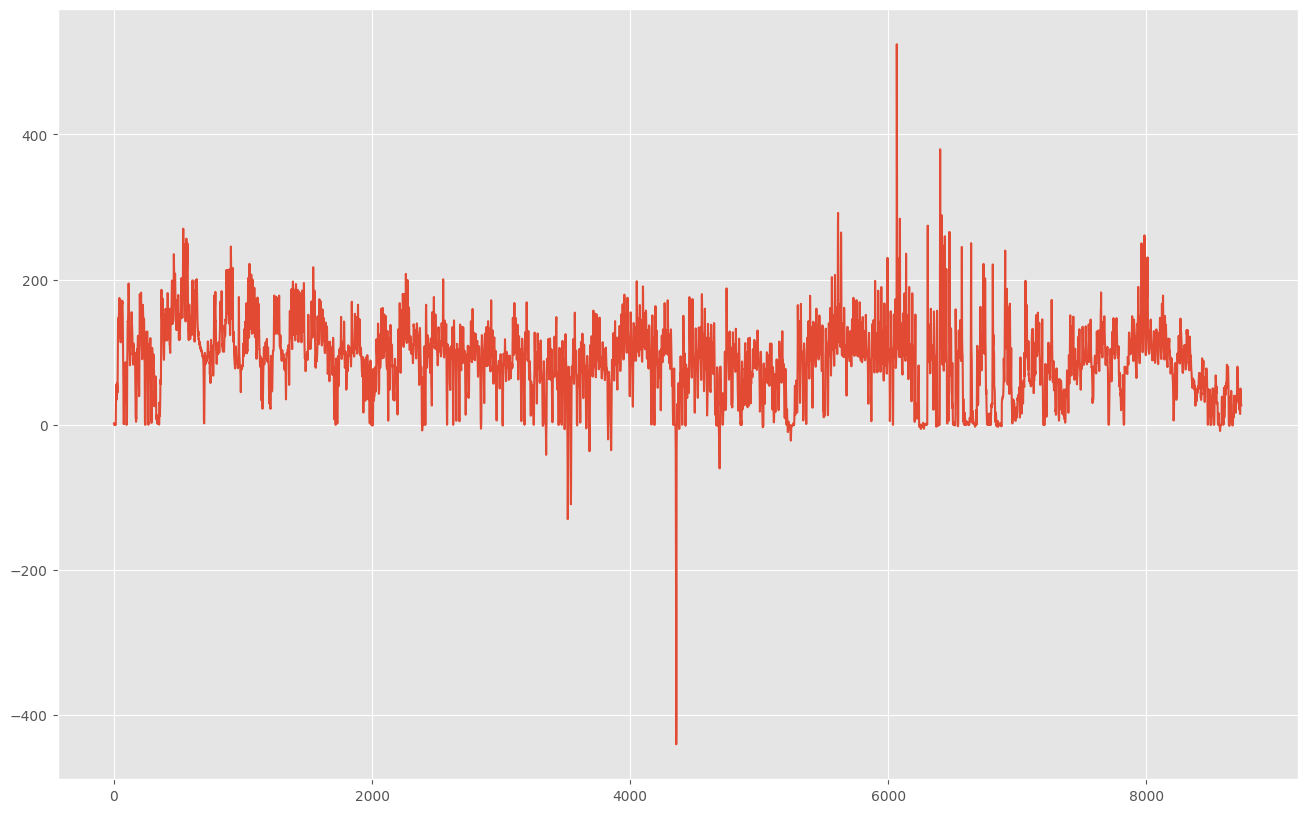

In [61]:
# Visualization
plt.plot(df['Price'])


In [62]:
# convert data to a matrix
y = df['Price'].values
x = df[df.columns[3:8]].values
x = x[1:]
N,D = x.shape
T = len(y)
print("T=%d" % (T))
print("N=%d, D=%d" % (N,D))

T=8736
N=8735, D=5


In [63]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(T)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1] #Using data in column 7 (ID=detector400026)
y_obs1 = y[ix_obs1]  

x_mis1 = x[ix_mis1-1]
x_obs1 = x[ix_obs1-1]

T_obs = len(ix_obs1)
T_mis = len(ix_mis1)
T = T_obs + T_mis
print("T_obs:", T_obs)
print("T_mis:", T_mis)

T_obs: 1748
T_mis: 6988


In [64]:
"""
B = np.random.normal(0,1.)
W = np.random.normal(0.,1., size=D)
h_prev = np.random.normal(0., 1)
tau = np.random.normal(0., 0.1)
carry = (B, W, h_prev, tau)

noises = np.random.normal(0., 1, size=T+100)
input_t = (x_t, noises)

h = lax.scan(f, carry, input_t, T+100)
carry_t, h_t = h

print(h_t.shape)
"""

'\nB = np.random.normal(0,1.)\nW = np.random.normal(0.,1., size=D)\nh_prev = np.random.normal(0., 1)\ntau = np.random.normal(0., 0.1)\ncarry = (B, W, h_prev, tau)\n\nnoises = np.random.normal(0., 1, size=T+100)\ninput_t = (x_t, noises)\n\nh = lax.scan(f, carry, input_t, T+100)\ncarry_t, h_t = h\n\nprint(h_t.shape)\n'

Define carry function for `jax.lax.scan`

In [65]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B, W, h_prev, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = B*h_prev + jnp.matmul(W, x_t) + tau*noise_t
    h_prev = h_t
    return (B, W, h_prev, tau), h_t

Define the NumPyro model

In [66]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    B = numpyro.sample("B", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(5), scale=jnp.ones(5)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-1,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B, W, h_prev, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-1)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return h_collection

In [67]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=0, x_t=x, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)


sample: 100%|██████████| 2000/2000 [04:45<00:00,  7.01it/s, 255 steps of size 1.56e-02. acc. prob=0.95]


In [68]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
             B      0.14      0.07      0.14      0.03      0.26    180.04      1.03
          W[0]      0.04      0.00      0.04      0.03      0.04    158.39      1.02
          W[1]      0.03      0.00      0.03      0.03      0.04    287.14      1.01
          W[2]     -0.06      0.01     -0.06     -0.07     -0.05    238.68      1.02
          W[3]     -0.04      0.01     -0.04     -0.05     -0.03    303.17      1.00
          W[4]     -0.06      0.01     -0.06     -0.07     -0.05    270.55      1.02
   noises_t[0]      0.00      1.01     -0.00     -1.70      1.58   2191.35      1.00
   noises_t[1]      0.02      0.95      0.04     -1.49      1.57   1721.41      1.00
   noises_t[2]     -0.01      1.01      0.01     -1.78      1.51   1330.05      1.00
   noises_t[3]      0.02      1.01      0.01     -1.63      1.70   1846.70      1.00
   noises_t[4]     -0.01      1.01      0.03     -1.59      1.60

In [69]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

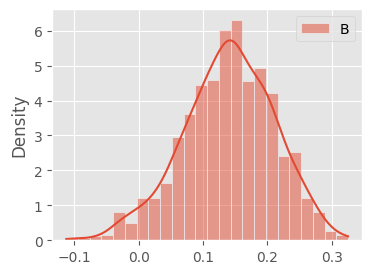

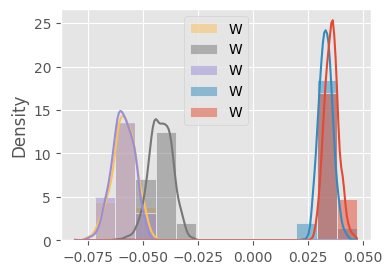

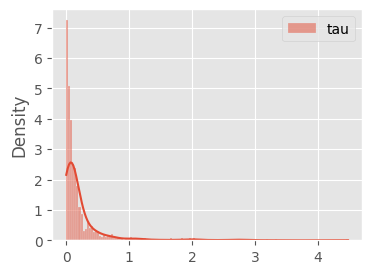

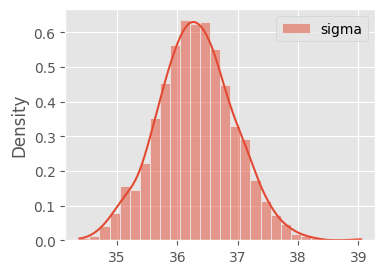

In [70]:
nodes = ["B", "W", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

In [71]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

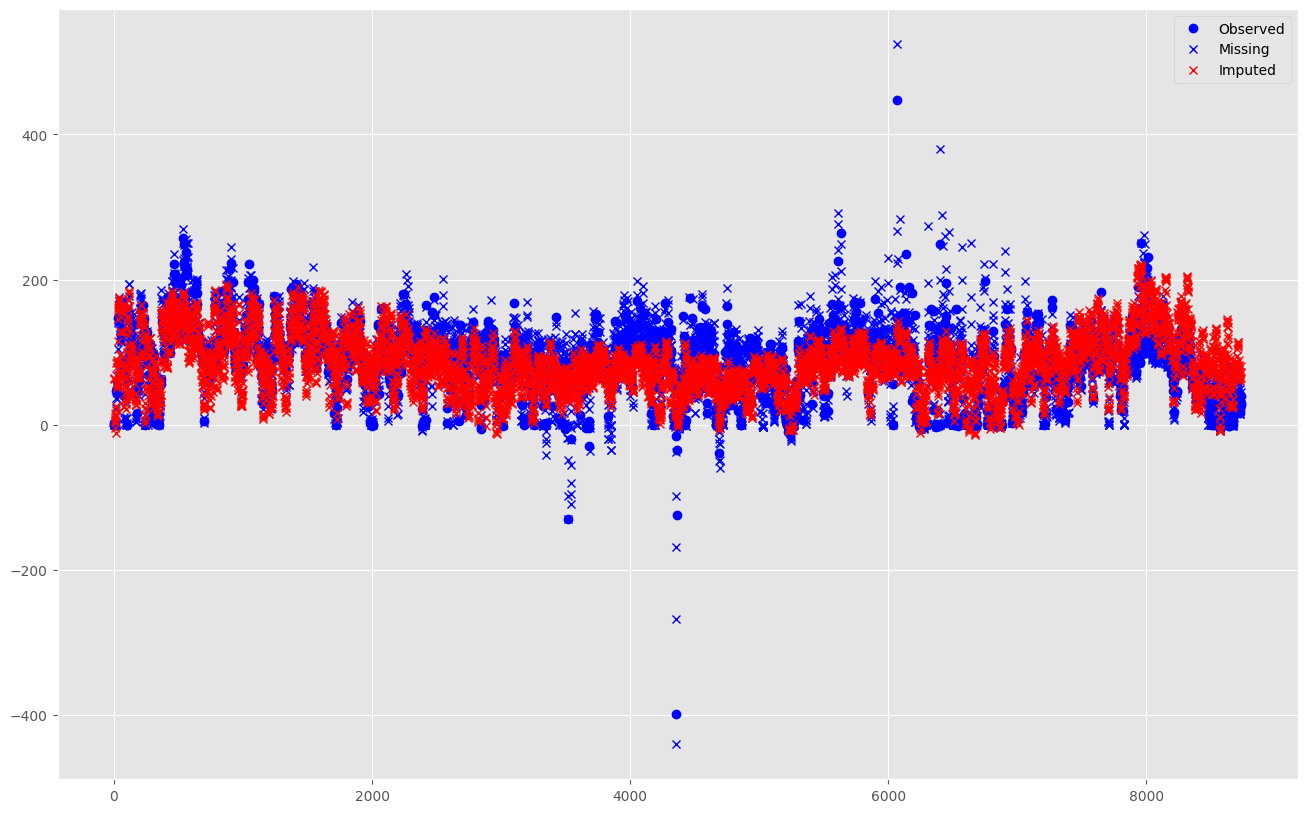

In [72]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"])

In [73]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [74]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.714
MAE: 26.32991
RMSE: 34.21021
R2: 0.502
